In [1]:
import pandas as pd
import numpy as np
import pycmap
import os.path
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

In [2]:
# calls api from cmap and uses my token to do that
api = pycmap.API(token = "d24b5240-ea3a-45bd-8174-fdb7830d805f")

In [3]:
## this is a way to call the seaflow metadata to python from google drive
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = '1Tsi7OWIZWfCQJqLDpId2aG_i-8Cp-p63PYjjvDkOtH4'
SAMPLE_RANGE_NAME = 'metadata'
creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.json', 'w') as token:
        token.write(creds.to_json())
try:
    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')

except HttpError as err:
    print(err)

In [4]:
seaflow_meta=pd.DataFrame(values)
seaflow_meta.columns=seaflow_meta.iloc[0]
seaflow_meta1 = seaflow_meta.iloc[1:]
seaflow_meta
# this seaflow_meta 

,cruise,Cruise ID,Project,R2R doi,Location,Year,Month,Day Of Year,Instrument,Ship,...,Discrete samples,Beads,Metadata,Filtration,Gating,Curation,Zenodo,Database size (Gb),References,Comments
0,cruise,Cruise ID,Project,R2R doi,Location,Year,Month,Day Of Year,Instrument,Ship,...,Discrete samples,Beads,Metadata,Filtration,Gating,Curation,Zenodo,Database size (Gb),References,Comments
1,CMOP_1,W0903A,CMOP,10.7284/900616,Columbia River,2009,May,,740,R/V Wecoma,...,,\n,,,,,,,,"this has no sds.tab file, will need to get data"
2,Thompson_0,TN243,H2O,10.7284/904001,Puget Sound,2009,November,,740,R/V Thomas G Thompson,...,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,,Ribalet et al. 2011,"Little/no Pro. ""Croco"" is probably cryptophytes."
3,CMOP_3,W1005A,CMOP,10.7284/904064,Columbia River,2010,May,141 - 147,740,R/V Wecoma,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,,,LAT/LON missing for nearly 400 points; no PAR;...
4,Thompson_1,TN248,-,10.7284/904006,Gulf of Alaska,2010,May,,740,R/V Thomas G Thompson,...,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,0.4,Pavlesky et al. 2013; Hyrkas et al. 2016,NO DATA IN R2R FOR THIS CRUISE; some lat missi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,HOT343,,HOT-343,,Aloha,2023,August,None,None,None,...,None,None,None,None,None,None,None,None,None,None
118,HOT344,,HOT-344,,Aloha,2023,September,None,None,None,...,None,None,None,None,None,None,None,None,None,None
119,HOT345,,HOT-345,,Aloha,2023,October,None,None,None,...,None,None,None,None,None,None,None,None,None,None
120,HOT346,,HOT-346,,Aloha,2023,November,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [5]:
def read_sfl(x):
    df = pd.read_csv(x, sep = '\t')
    cruise_split = x.rsplit('/',1)[-1]
    #output will be a string
    cruise_short = cruise_split.replace('.sfl', '')
    cruise_list = cruise_short.split('_')
    if len(cruise_list) > 2:
        cruise = "_".join([cruise_list[0], cruise_list[1]])
    elif len(cruise_list) == 2:
        cruise = cruise_list[0]
    ship = seaflow_meta.loc[seaflow_meta['cruise'] ==  cruise, 'Ship'].values[0]
    print(ship)
    df['cruise'] = cruise
    df['ship'] = ship
    return df

#### .values converts pd.series to list but we had to get string from the list which is the first one 

In [6]:
sfl = read_sfl("https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/master/curated/TN397_130_130.sfl")

R/V Thomas G Thompson


In [12]:
sfl

,FILE,DATE,FILE DURATION,LAT,LON,CONDUCTIVITY,SALINITY,OCEAN TEMP,PAR,BULK RED,STREAM PRESSURE,EVENT RATE,cruise,ship
0,2021_323/2021-11-19T03-01-27+00-00,2021-11-19T03:01:27+00:00,180.073,32.706600,-117.236300,NaN,NaN,NaN,0.029,115.7579,0.75,0,TN397_130,R/V Thomas G Thompson
1,2021_323/2021-11-19T03-04-27+00-00,2021-11-19T03:04:27+00:00,180.080,32.706600,-117.236300,NaN,NaN,NaN,0.029,91.6572,0.75,0,TN397_130,R/V Thomas G Thompson
2,2021_323/2021-11-19T03-07-28+00-00,2021-11-19T03:07:28+00:00,180.035,32.706600,-117.236300,NaN,NaN,NaN,0.028,93.5062,0.75,0,TN397_130,R/V Thomas G Thompson
3,2021_323/2021-11-19T03-10-28+00-00,2021-11-19T03:10:28+00:00,27.204,32.706600,-117.236300,NaN,NaN,NaN,0.029,93.5062,0.75,0,TN397_130,R/V Thomas G Thompson
4,2021_323/2021-11-19T03-11-26+00-00,2021-11-19T03:11:26+00:00,180.040,32.706600,-117.236300,NaN,NaN,NaN,0.025,138.7690,0.75,0,TN397_130,R/V Thomas G Thompson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11038,2021_348/2021-12-14T22-16-28+00-00,2021-12-14T22:16:28+00:00,180.125,19.192050,-156.297450,5.420927,34.818908,26.324992,2468.471,74.5972,2.34,0,TN397_130,R/V Thomas G Thompson
11039,2021_348/2021-12-14T22-19-28+00-00,2021-12-14T22:19:28+00:00,162.503,19.200191,-156.303327,5.419084,34.815336,26.312100,2474.775,79.6548,2.34,0,TN397_130,R/V Thomas G Thompson
11040,2021_348/2021-12-14T22-35-49+00-00,2021-12-14T22:35:49+00:00,180.096,19.247258,-156.337150,5.423963,34.837700,26.329175,1878.722,203.7869,2.34,0,TN397_130,R/V Thomas G Thompson
11041,2021_348/2021-12-14T22-38-49+00-00,2021-12-14T22:38:49+00:00,180.108,19.255750,-156.343075,5.424074,34.836658,26.331650,1780.900,203.7869,2.34,0,TN397_130,R/V Thomas G Thompson


In [8]:
pd.to_datetime(sfl['DATE'])
# this converts sfl date column from object type to datetime in UTC

datetime_index = pd.DatetimeIndex(sfl.DATE.values).tz_convert('UTC')
df2 = sfl.set_index(datetime_index).reset_index()
df2.rename(columns={"index": "Date"}, inplace = True)
df2.drop(columns = ['DATE'], inplace = True)

# convert datetime64 to datetimeindex for groupby function to work
## i changed df because i was scared to mess up sfl df i was working with so I may have to change code to alter sfl df

In [22]:
df2

,Date,FILE,FILE DURATION,LAT,LON,CONDUCTIVITY,SALINITY,OCEAN TEMP,PAR,BULK RED,STREAM PRESSURE,EVENT RATE,cruise,ship
0,2021-11-19 03:01:27+00:00,2021_323/2021-11-19T03-01-27+00-00,180.073,32.706600,-117.236300,NaN,NaN,NaN,0.029,115.7579,0.75,0,TN397_130,R/V Thomas G Thompson
1,2021-11-19 03:04:27+00:00,2021_323/2021-11-19T03-04-27+00-00,180.080,32.706600,-117.236300,NaN,NaN,NaN,0.029,91.6572,0.75,0,TN397_130,R/V Thomas G Thompson
2,2021-11-19 03:07:28+00:00,2021_323/2021-11-19T03-07-28+00-00,180.035,32.706600,-117.236300,NaN,NaN,NaN,0.028,93.5062,0.75,0,TN397_130,R/V Thomas G Thompson
3,2021-11-19 03:10:28+00:00,2021_323/2021-11-19T03-10-28+00-00,27.204,32.706600,-117.236300,NaN,NaN,NaN,0.029,93.5062,0.75,0,TN397_130,R/V Thomas G Thompson
4,2021-11-19 03:11:26+00:00,2021_323/2021-11-19T03-11-26+00-00,180.040,32.706600,-117.236300,NaN,NaN,NaN,0.025,138.7690,0.75,0,TN397_130,R/V Thomas G Thompson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11038,2021-12-14 22:16:28+00:00,2021_348/2021-12-14T22-16-28+00-00,180.125,19.192050,-156.297450,5.420927,34.818908,26.324992,2468.471,74.5972,2.34,0,TN397_130,R/V Thomas G Thompson
11039,2021-12-14 22:19:28+00:00,2021_348/2021-12-14T22-19-28+00-00,162.503,19.200191,-156.303327,5.419084,34.815336,26.312100,2474.775,79.6548,2.34,0,TN397_130,R/V Thomas G Thompson
11040,2021-12-14 22:35:49+00:00,2021_348/2021-12-14T22-35-49+00-00,180.096,19.247258,-156.337150,5.423963,34.837700,26.329175,1878.722,203.7869,2.34,0,TN397_130,R/V Thomas G Thompson
11041,2021-12-14 22:38:49+00:00,2021_348/2021-12-14T22-38-49+00-00,180.108,19.255750,-156.343075,5.424074,34.836658,26.331650,1780.900,203.7869,2.34,0,TN397_130,R/V Thomas G Thompson


In [9]:
PAR = df2[df2.PAR.notnull()]
sfl_hourly = df2.groupby([pd.Grouper(key = 'Date', freq = 'H'), 'cruise']).agg({'PAR': 'mean'}).reset_index()
sfl_hourly.head()
# goal here is to group cruise and date column and . agg mean par to get hourly par data

,Date,cruise,PAR
0,2021-11-19 03:00:00+00:00,TN397_130,0.027400
1,2021-11-19 14:00:00+00:00,TN397_130,32.932143
2,2021-11-19 15:00:00+00:00,TN397_130,257.557450
3,2021-11-19 16:00:00+00:00,TN397_130,616.760250
4,2021-11-19 17:00:00+00:00,TN397_130,919.520650


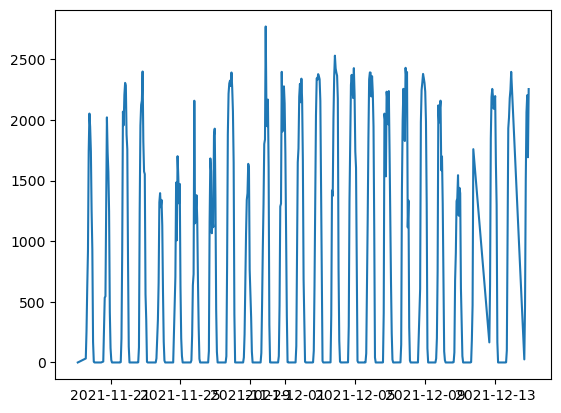

In [11]:
x = sfl_hourly.Date
y = sfl_hourly.PAR
plt.plot(x, y)

In [20]:
sfl_hourly.PAR = 10**6 * sfl_hourly.PAR * 24 * 60 * 60
# time to convert PAR units from microeinstein to einstein to match satellite data

In [ ]:
min_lat = df2[df2.PAR.notnull()] # try to find min & max value for non-NaN values in lat and lon columns
max_lat = 

min_lon =
max_lon =

sfl_daily = df2.groupby([pd.Grouper(key = 'Date', freq = 'D'), 'cruise', 'ship']).agg({'PAR': 'mean'}).reset_index()
# using group by to get the daily mean of par based on cruise, ship, etc. and removes any NaN values found. gets minimum and max of lat and lon based on daily scale